# GraphSAGE模型复现
**参考资料：**

* [【图神经网络(GraphSAGE)】Pytorch代码](https://zhuanlan.zhihu.com/p/410407148)

### 导入相关python库

In [39]:
import math
import torch
import random
import pyhocon
import argparse
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from collections import defaultdict

### GraphSAGE参数配置

In [40]:
parser = argparse.ArgumentParser(description='pytorch version of GraphSAGE')
parser.add_argument('--dataSet', type=str, default='cora')                # 数据集名字
parser.add_argument('--agg_func', type=str, default='MEAN')               # 采用什么聚合函数
parser.add_argument('--epochs', type=int, default=50)                     # 迭代次数
parser.add_argument('--b_sz', type=int, default=20)                       # batch大小
parser.add_argument('--seed', type=int, default=824)                      # 随机种子
parser.add_argument('--cuda', action='store_true',help='use CUDA')        # 是否使用GPU
parser.add_argument('--gcn', action='store_true')                         # 师傅使用GCN
parser.add_argument('--learn_method', type=str, default='sup')            # 选择损失函数         
parser.add_argument('--max_vali_f1', type=float, default=0)
parser.add_argument('--name', type=str, default='debug')                  # 保存文件名
# parser.add_argument('--config', type=str, default='./experiments.conf')   # 获取的一些配置文件
#args = parser.parse_args()                                               # pychram 中使用
args = parser.parse_known_args()[0]                                       # jupyter 中使用
device = torch.device("cuda" if args.cuda else "cpu")

In [41]:
args

Namespace(dataSet='cora', agg_func='MEAN', epochs=50, b_sz=20, seed=824, cuda=False, gcn=False, learn_method='sup', max_vali_f1=0, name='debug')

### 数据加载函数

In [42]:
class DataCenter(object):
    def __init__(self):
        super(DataCenter, self).__init__()
        # self.config = config

    def load_dataSet(self, dataSet='cora'):
        if dataSet == 'cora':
            cora_content_file = './cora/cora.content'        # 获取节点特征信息文件路径
            cora_cite_file = './cora/cora.cites'             # 获取边信息
            feat_data = []
            labels = []                                                      # 每个节点对应的便序列
            node_map = {}                                                    # 节点的index
            label_map = {}                                                   # 标签的index
            
            with open(cora_content_file) as fp:                              # 打开节点特性信息文件
                for i, line in enumerate(fp):
                    info = line.strip().split()                              
                    feat_data.append([float(x) for x in info[1:-1]])         # 节点特征信息
                    node_map[info[0]] = i                                    # 节点的index  值->ID
                    if not info[-1] in label_map:                            # 判断标签是否已存在
                        label_map[info[-1]] = len(label_map)                 # 标签的index  值->ID
                    labels.append(label_map[info[-1]])                       # 节点对应的标签信息
            feat_data = np.asarray(feat_data)                                # 转换成numpy格式
            labels = np.asarray(labels, dtype=np.int64)                      # 转换成numpy格式
            adj_lists = defaultdict(set)                                     # 定义存放set的字典，访问不存在数据不报错
            
            with open(cora_cite_file) as fp:                                 # 打开边信息文件
                for i, line in enumerate(fp):
                    info = line.strip().split()             
                    assert len(info) == 2
                    paper1 = node_map[info[0]]                               
                    paper2 = node_map[info[1]]
                    adj_lists[paper1].add(paper2)
                    adj_lists[paper2].add(paper1)                            # 得到的字典可以查找每一个点的邻居节点
            assert len(feat_data) == len(labels) == len(adj_lists)
            test_indexs, val_indexs, train_indexs = self._split_data(feat_data.shape[0])  # 把数据分为 训练，验证，测试集

            setattr(self, dataSet+'_test', test_indexs)
            setattr(self, dataSet+'_val', val_indexs)
            setattr(self, dataSet+'_train', train_indexs)

            setattr(self, dataSet+'_feats', feat_data)
            setattr(self, dataSet+'_labels', labels)
            setattr(self, dataSet+'_adj_lists', adj_lists)
            
    def _split_data(self, num_nodes, test_split = 3, val_split = 6):         # 把数据分为 训练，验证，测试集
        rand_indices = np.random.permutation(num_nodes)                      # 每3个数据中选一个测试集，每6个数据中选一个验证集。
                                                                                    
        test_size = num_nodes // test_split
        val_size = num_nodes // val_split
        train_size = num_nodes - (test_size + val_size)

        test_indexs = rand_indices[:test_size]
        val_indexs = rand_indices[test_size:(test_size+val_size)]
        train_indexs = rand_indices[(test_size+val_size):]

        return test_indexs, val_indexs, train_indexs

### 加载Cora数据集

In [43]:
random.seed(args.seed)                                                # 固定随机种子
np.random.seed(args.seed)                                             # 固定随机种子
torch.manual_seed(args.seed)                                          # 固定随机种子
torch.cuda.manual_seed_all(args.seed)                                 # 固定随机种子

In [44]:
ds = args.dataSet
dataCenter = DataCenter()
dataCenter.load_dataSet(ds)
test_nodes = getattr(dataCenter, ds+'_test')              # 获取测试集    
val_nodes = getattr(dataCenter, ds+'_val')                # 获取验证集
train_nodes = getattr(dataCenter, ds+'_train')            # 获取测试集
labels = getattr(dataCenter, ds+'_labels')                # 获取标签
adj_lists = getattr(dataCenter, ds+'_adj_lists')          # 邻接矩阵

In [45]:
print(test_nodes.shape,val_nodes.shape,train_nodes.shape,labels.shape)

(902,) (451,) (1355,) (2708,)


In [46]:
features = torch.FloatTensor(getattr(dataCenter, ds+'_feats')).to(device)  
features.shape

torch.Size([2708, 1433])

## GraphSAGE 模型

### SAGELayer

In [47]:
class SageLayer(nn.Module):
    def __init__(self, input_size, out_size, gcn=False): 
        super(SageLayer, self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        self.gcn = gcn
        self.weight = nn.Parameter(torch.FloatTensor(out_size, self.input_size if self.gcn else 2 * self.input_size)) # 创建weight
        self.init_params()                                                # 初始化参数

    def init_params(self):
        for param in self.parameters():
            nn.init.xavier_uniform_(param)

    def forward(self, self_feats, aggregate_feats, neighs=None):
        if not self.gcn:
            combined = torch.cat([self_feats, aggregate_feats], dim=1)   # concat自己信息和邻居信息
        else:
            combined = aggregate_feats
        combined = F.relu(self.weight.mm(combined.t())).t()
        return combined

### 分类器

In [48]:
class Classification(nn.Module):         # 把GraphSAGE的输出链接全连接层每个节点映射到7维
    def __init__(self, emb_size, num_classes):
        super(Classification, self).__init__()
        self.layer = nn.Sequential(nn.Linear(emb_size, num_classes))      
        self.init_params()

    def init_params(self):
        for param in self.parameters():
            if len(param.size()) == 2:
                nn.init.xavier_uniform_(param)

    def forward(self, embeds):
        logists = torch.log_softmax(self.layer(embeds), 1)
        return logists

### GrapeSAGE Model 

In [49]:
class GraphSage(nn.Module):  ## GraphSage模型定义

    def __init__(self, num_layers, input_size, out_size, raw_features, adj_lists, device, gcn=False, agg_func='MEAN'):
        super(GraphSage, self).__init__()

        self.input_size = input_size                                  # 输入尺寸   1433
        self.out_size = out_size                                      # 输出尺寸   128
        self.num_layers = num_layers                                  # 聚合层数   2
        self.gcn = gcn                                                # 是否使用GCN
        self.device = device                                          # 使用训练设备
        self.agg_func = agg_func                                      # 聚合函数
        self.raw_features = raw_features                              # 节点特征
        self.adj_lists = adj_lists                                    # 边
        
        for index in range(1, num_layers + 1):
            layer_size = out_size if index != 1 else input_size       # 如果index==1，这中间特征为1433，如果！=1。则特征数为128。
            setattr(self, 'sage_layer'+str(index), SageLayer(layer_size, out_size, gcn=self.gcn))  

    def forward(self, nodes_batch):
        lower_layer_nodes = list(nodes_batch)                          # 把当前训练的节点转换成list
        # [527, 1681, 439, 2007, 1439, 963, 699, 131, 1003, 1, 658, 1660, 16, 716, 245, 2577, 501, 1582, 1081, 944]

        nodes_batch_layers = [(lower_layer_nodes,)]                    # 放入的训练节点
        # [([527, 1681, 439, 2007, 1439, 963, 699, 131, 1003, 1, 658, 1660, 16, 716, 245, 2577, 501, 1582, 1081, 944],)]

        for i in range(self.num_layers):                               # 遍历每一次聚合，获得neighbors
            lower_samp_neighs, lower_layer_nodes_dict, lower_layer_nodes= self._get_unique_neighs_list(lower_layer_nodes)  
            nodes_batch_layers.insert(0, (lower_layer_nodes, lower_samp_neighs, lower_layer_nodes_dict))
                                     # batch涉及到的所有节点，本身+邻居 ，      节点编号->当前字典中顺序index    
            #[([涉及到的所有节点],[{邻居+自己},{邻居+自己}],{节点index}),([batch节点]),] 
        assert len(nodes_batch_layers) == self.num_layers + 1

        pre_hidden_embs = self.raw_features

        for index in range(1, self.num_layers+1):
            nb = nodes_batch_layers[index][0]                           # 聚合自己和邻居的节点
            pre_neighs = nodes_batch_layers[index-1]                    # 涉及到的所有节点，自己和邻居节点，邻居节点编号->字典中编号

            aggregate_feats = self.aggregate(nb, pre_hidden_embs, pre_neighs)   # 聚合函数。聚合的节点， 节点特征，集合节点邻居信息
            sage_layer = getattr(self, 'sage_layer'+str(index))

            if index > 1:
                nb = self._nodes_map(nb, pre_hidden_embs, pre_neighs)   # 第一层的batch节点，没有进行转换
            cur_hidden_embs = sage_layer(self_feats=pre_hidden_embs[nb], aggregate_feats=aggregate_feats)  
                                                                        # 进入SageLayer。weight*concat(node,neighbors)
            pre_hidden_embs = cur_hidden_embs

        return pre_hidden_embs

    def _nodes_map(self, nodes, hidden_embs, neighs):
        layer_nodes, samp_neighs, layer_nodes_dict = neighs
        assert len(samp_neighs) == len(nodes)
        index = [layer_nodes_dict[x] for x in nodes]                    # 记录将上一层的节点编号。
        return index

    def _get_unique_neighs_list(self, nodes, num_sample=10):
        _set = set
        to_neighs = [self.adj_lists[int(node)] for node in nodes]       # self.adj_lists边矩阵，获取节点的邻居

        if not num_sample is None:                                      # 对邻居节点进行采样，如果大于邻居数据，则进行采样
            _sample = random.sample                                     # 节点长度小于10 
            samp_neighs = [_set(_sample(to_neigh, num_sample)) if len(to_neigh) >= num_sample else to_neigh for to_neigh in to_neighs]
        else:
            samp_neighs = to_neighs

        samp_neighs = [samp_neigh | set([nodes[i]]) for i, samp_neigh in enumerate(samp_neighs)]  # 加入本身节点

        _unique_nodes_list = list(set.union(*samp_neighs))               # 这个batch涉及到的所有节点

        i = list(range(len(_unique_nodes_list)))                         # 建立编号
        unique_nodes = dict(list(zip(_unique_nodes_list, i)))            # 节点编号->当前字典中顺序index

        return samp_neighs, unique_nodes, _unique_nodes_list             # 聚合自己和邻居节点，点的dict，batch涉及到的所有节点


    def aggregate(self, nodes, pre_hidden_embs, pre_neighs, num_sample=10):
        unique_nodes_list, samp_neighs, unique_nodes = pre_neighs        # batch涉及到的所有节点,本身+邻居,邻居节点编号->字典中编号  
        assert len(nodes) == len(samp_neighs)
        indicator = [(nodes[i] in samp_neighs[i]) for i in range(len(samp_neighs))]  # 是否包含本身
        assert (False not in indicator)

        if not self.gcn:
            samp_neighs = [(samp_neighs[i]-set([nodes[i]])) for i in range(len(samp_neighs))]  # 在把中心节点去掉
        if len(pre_hidden_embs) == len(unique_nodes):                     # 保留需要使用的节点特征。
            embed_matrix = pre_hidden_embs
        else:
            embed_matrix = pre_hidden_embs[torch.LongTensor(unique_nodes_list)]     
                                                      
        mask = torch.zeros(len(samp_neighs), len(unique_nodes))           # (本层节点数量，邻居节点数量)
        column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]  # 保存列 每一行对应的邻居真实index做为列。
        row_indices = [i for i in range(len(samp_neighs)) for j in range(len(samp_neighs[i]))]# 保存行 每行邻居数
        mask[row_indices, column_indices] = 1                             # 构建邻接矩阵;

        if self.agg_func == 'MEAN':
            num_neigh = mask.sum(1, keepdim=True)                         # 按行求和，保持和输入一个维度
            mask = mask.div(num_neigh).to(embed_matrix.device)            # 归一化操作
            aggregate_feats = mask.mm(embed_matrix)                       # 矩阵相乘，相当于聚合周围邻接信息求和

        elif self.agg_func == 'MAX':
            indexs = [x.nonzero() for x in mask==1]
            aggregate_feats = []
            for feat in [embed_matrix[x.squeeze()] for x in indexs]:
                if len(feat.size()) == 1:
                    aggregate_feats.append(feat.view(1, -1))
                else:
                    aggregate_feats.append(torch.max(feat,0)[0].view(1, -1))
            aggregate_feats = torch.cat(aggregate_feats, 0)

        return aggregate_feats

In [50]:
num_layers = 2
hidden_emb_size = 128
graphSage = GraphSage(num_layers, features.size(1), hidden_emb_size, features, getattr(dataCenter, ds+'_adj_lists'), device, gcn=args.gcn, agg_func=args.agg_func)


In [51]:
num_labels = len(set(getattr(dataCenter, ds+'_labels')))              # label的数量
num_labels

7

In [52]:
classification = Classification(hidden_emb_size, num_labels)

In [53]:
def apply_model(dataCenter, ds, graphSage, classification, b_sz, device, learn_method):
    # test_nodes = getattr(dataCenter, ds+'_test')              # 获取测试集    
    # val_nodes = getattr(dataCenter, ds+'_val')                # 获取验证集
    train_nodes = getattr(dataCenter, ds+'_train')            # 获取测试集
    labels = getattr(dataCenter, ds+'_labels')                # 获取标签
    train_nodes = shuffle(train_nodes)                        # 打乱训练数据
    models = [graphSage, classification]                      # models

    params = []
    for model in models:                                      # 初始化模型参数
        for param in model.parameters():
            if param.requires_grad:
                params.append(param)

    optimizer = torch.optim.SGD(params, lr=0.7)               # 梯度优化算法
    optimizer.zero_grad()                                     # 梯度清零
    for model in models:                                 
        model.zero_grad()
                                        
    batches = math.ceil(len(train_nodes) / b_sz)              # 有多少个batches
    visited_nodes = set()

    for index in range(batches):
        nodes_batch = train_nodes[index*b_sz:(index+1)*b_sz]  # 选择当前需要训练的节点
        visited_nodes |= set(nodes_batch)
        labels_batch = labels[nodes_batch]
        embs_batch = graphSage(nodes_batch)                   # 学习到节点表征

        if learn_method == 'sup':                             # 监督学习
            logists = classification(embs_batch)              # 分类函数
            loss_sup = -torch.sum(logists[range(logists.size(0)), labels_batch], 0)  # 计算损失
            loss_sup /= len(nodes_batch)                      # 计算平均损失
            loss = loss_sup                                   
        # print('Step [{}/{}], Loss: {:.4f}, Dealed Nodes [{}/{}] '.format(index+1, batches, loss.item(), len(visited_nodes), len(train_nodes)))
        loss.backward()                                       # 反向传播
        for model in models:
            nn.utils.clip_grad_norm_(model.parameters(), 5)  
        optimizer.step()                                      # 更新梯度
        optimizer.zero_grad()                                 # 梯度清零
        for model in models:
            model.zero_grad() 

    return graphSage, classification

### 测试函数

In [54]:
def evaluate(dataCenter, ds, graphSage, classification, max_vali_f1):
    test_nodes = getattr(dataCenter, ds+'_test')          # 获取测试集
    val_nodes = getattr(dataCenter, ds+'_val')            # 获取验证集
    labels = getattr(dataCenter, ds+'_labels')            # 获取标签
    models = [graphSage, classification]                  # 获取训练后的模型
    params = []                                           # 保存模型参数
    for model in models:
        for param in model.parameters():
            if param.requires_grad:
                param.requires_grad = False           # 取消梯度计算
                params.append(param)

    embs = graphSage(val_nodes)               # 验证集F1得分
    logists = classification(embs)
    _, predicts = torch.max(logists, 1)
    labels_val = labels[val_nodes]
    assert len(labels_val) == len(predicts)
    # comps = zip(labels_val, predicts.data)
    vali_f1 = f1_score(labels_val, predicts.cpu().data, average="micro")
    print("Validation F1:", vali_f1)

    if vali_f1 > max_vali_f1:
        max_vali_f1 = vali_f1
        embs = graphSage(test_nodes)          # 测试集F1得分
        logists = classification(embs)
        _, predicts = torch.max(logists, 1)
        labels_test = labels[test_nodes]
        assert len(labels_test) == len(predicts)
        # comps = zip(labels_test, predicts.data)
        test_f1 = f1_score(labels_test, predicts.cpu().data, average="micro")
        print("Test F1:", test_f1)
        # torch.save(models, 'model_best_{}_ep{}_{:.4f}.torch'.format(name, cur_epoch, test_f1))

    for param in params:
        param.requires_grad = True         # 还原梯度

    return max_vali_f1

In [55]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)        # 忽略警告

for epoch in range(args.epochs):
    print('----------------------EPOCH %d-----------------------' % epoch)
    graphSage, classification = apply_model(dataCenter, ds, graphSage, classification, args.b_sz, device, args.learn_method)
    if args.learn_method != 'unsup':
        args.max_vali_f1 = evaluate(dataCenter, ds, graphSage, classification, args.max_vali_f1)

----------------------EPOCH 0-----------------------
Validation F1: 0.8425720620842572
Test F1: 0.8314855875831486
----------------------EPOCH 1-----------------------
Validation F1: 0.8536585365853658
Test F1: 0.8470066518847007
----------------------EPOCH 2-----------------------
Validation F1: 0.8536585365853658
----------------------EPOCH 3-----------------------
Validation F1: 0.8669623059866962
Test F1: 0.8725055432372505
----------------------EPOCH 4-----------------------
Validation F1: 0.8758314855875832
Test F1: 0.8813747228381374
----------------------EPOCH 5-----------------------
Validation F1: 0.8802660753880266
Test F1: 0.876940133037694
----------------------EPOCH 6-----------------------
Validation F1: 0.8780487804878049
----------------------EPOCH 7-----------------------
Validation F1: 0.8802660753880266
----------------------EPOCH 8-----------------------
Validation F1: 0.8802660753880266
----------------------EPOCH 9-----------------------
Validation F1: 0.88248337

In [60]:
graphSage.eval()
classification.eval()
with torch.no_grad():  # 显著减少显存占用
    embs = graphSage(test_nodes)               # 测试集最终F1得分
    logists = classification(embs)
    _, predicts = torch.max(logists, 1)
    labels_test = labels[test_nodes]
    assert len(labels_test) == len(predicts)
    # comps = zip(labels_test, predicts.data)
    test_f1 = f1_score(labels_test, predicts.cpu().data, average="micro")
    print("Test F1:", test_f1)

Test F1: 0.8780487804878049


In [64]:
output = logists
output.shape

torch.Size([902, 7])

In [62]:
labels_test.shape

(902,)

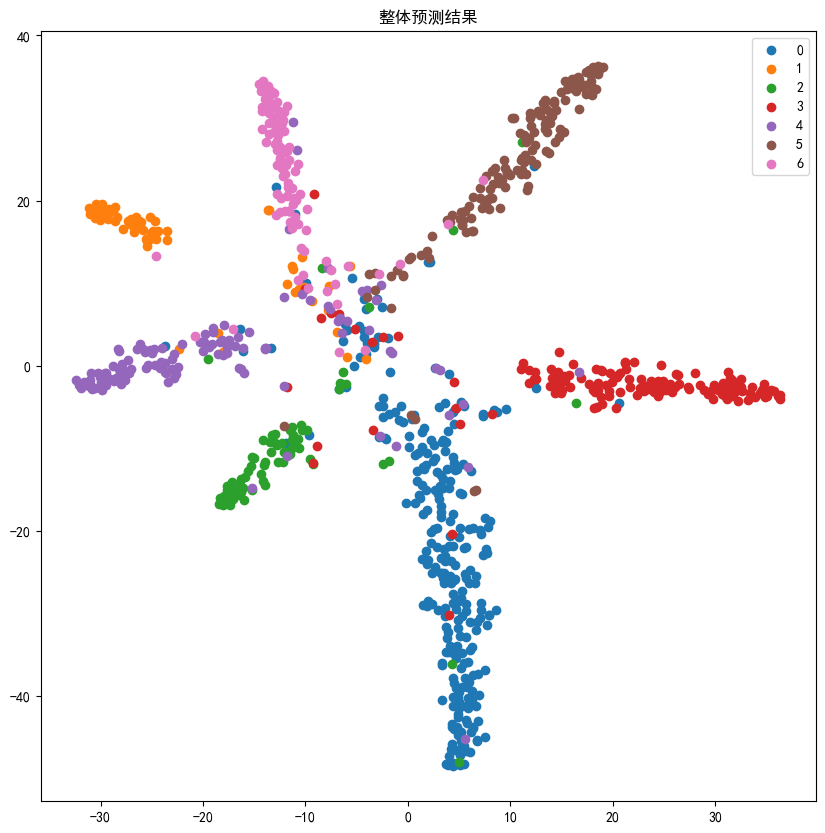

In [63]:
# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
out = tsne.fit_transform(output)

plt.figure(figsize=(10,10))
for i in range(7):
    indices = labels_test == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.title("整体预测结果")
plt.legend()
plt.show()